In [57]:
%load_ext autoreload
%autoreload 2

import torch

import matplotlib.pyplot as plt
import seaborn as sns


from mixture_model.model import MixtureModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mixture_model = MixtureModel.from_pretrained("./checkpoints/mixture_model_20240526_234542.pt").to(device)
mixture_model.eval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MixtureModel(
  (encoder): MixtureModelEncoder(
    (gnn_layers): ModuleList(
      (0): ECCConv(4, 16)
      (1): BatchNorm(16)
      (2): PReLU(num_parameters=1)
      (3): ECCConv(16, 32)
      (4): BatchNorm(32)
      (5): PReLU(num_parameters=1)
      (6): ECCConv(32, 64)
      (7): BatchNorm(64)
      (8): PReLU(num_parameters=1)
      (9): ECCConv(64, 128)
      (10): BatchNorm(128)
      (11): PReLU(num_parameters=1)
    )
    (z_head): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=32, bias=True)
    )
    (graph_pooling): GlobalGraphPooling(
      (fc_i): Linear(in_features=128, out_features=128, bias=True)
      (fc_j): Linear(in_features=128, out_features=128, bias=True)
    )
    (eta_head): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): MixtureModelD

In [63]:
num_generated_mols = 100000
num_atoms = torch.tensor([9] * num_generated_mols, dtype=torch.int64, device=device)

In [64]:
eta = mixture_model.decoder.sample_eta(num_atoms, device)
eta.shape

torch.Size([100000, 32])

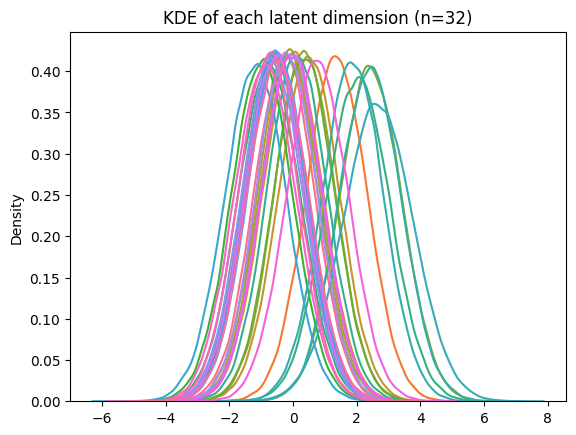

In [65]:
eta_cpu = eta.detach().cpu().numpy()
latent_dim = eta.shape[1]
for dim in range(eta.shape[1]):
    sns.kdeplot(eta_cpu[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

plt.title(f'KDE of each latent dimension (n={latent_dim})')
plt.show()

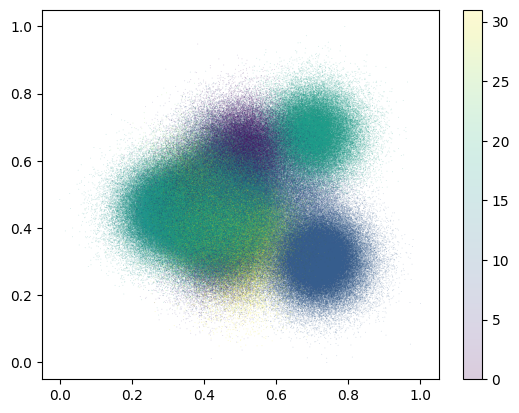

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Assume mixture_model and other necessary variables are already defined

pi = mixture_model.decoder.decode_eta(eta)
c = mixture_model.decoder.sample_c(pi=pi, num_atoms=num_atoms)
z = mixture_model.decoder.sample_z(c=c).detach().cpu().numpy()

# Get cluster labels from one-hot encoded vectors
cluster_labels = np.argmax(c.detach().cpu().numpy(), axis=1)

# Perform PCA and normalization
pca_fitted = PCA(n_components=2).fit(z)
Z_pca = pca_fitted.transform(z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

# Create scatter plot with colors according to cluster labels
scatter = plt.scatter(x=df['x'], y=df['y'], c=cluster_labels, marker='.', s=2, alpha=0.2, edgecolors='none', cmap='viridis')
plt.colorbar(scatter)
plt.show()

In [50]:
means = mixture_model.decoder.cluster_means.detach().cpu()[0]

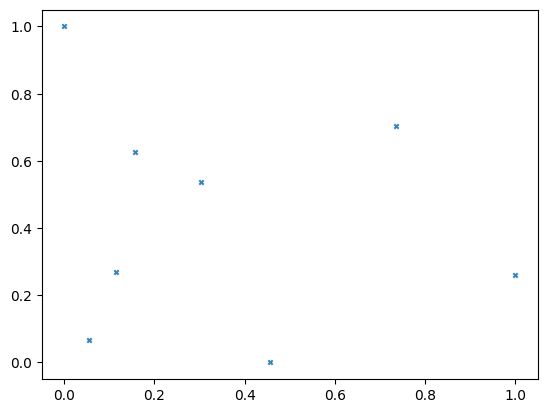

In [51]:
# do pca and normalize
Z_pca = pca_fitted.transform(means)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], marker='x',
            s=10,alpha=0.9)
plt.show()